# Logistic Regression Analysis

This Logistic Regression analysis was made from real data to predict turnover in an unnamed company. The resulting predictive accuracy of the model was 75%.

In [2]:
import warnings
warnings.simplefilter(action='ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import os
import requests
import io

# Import sklearn functions
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

#Get data from Github
url = "https://raw.githubusercontent.com/nickjmichal/projects/main/EMPLOYEE%20DATA%20-%20obfuscated.csv"
download = requests.get(url).content

dfbase = pd.read_csv(io.StringIO(download.decode('utf-8')))

dfbase.head()

,Department,Job Title,Job Area,Standard Hours,Marital Status,Hourly Rate,FULLTIME_IND,Days in Role,days_employed,Years of Service,...,Days Employed When Survey Sent,Days With Company on Submit of Survey,PC,Division,Unnamed: 18,Job Title.1,ED & DHS Average Rating,Immediate Supervisor Average Rating,Communication and Campus Average Rating,Department Morale Rating
0,58-Facility Admin,Executive Director,Executive Director,40.0,M,55.57,1,365.0,365,1.000000,...,365,365,411,North Ohio,Region A,Executive Director,0.00,5.00,4.20,4
1,58-Facility Admin,Executive Director,Executive Director,40.0,S,42.12,1,479.0,870,2.383562,...,0,30,518,North Michigan,Region B,Executive Director,4.88,5.00,5.00,5
2,58-Facility Admin,AP/Payroll Coordinator,Finance,40.0,S,14.90,1,564.0,731,2.002740,...,0,182,101,Southwest Indiana,Region C,AP/Payroll Coordinator,5.00,5.00,5.00,4
3,58-Facility Admin,AP/Payroll Coordinator,Finance,40.0,M,20.18,1,567.0,567,1.553425,...,0,183,145,South Kentucky,Region D,AP/Payroll Coordinator,3.00,4.63,3.83,4
4,58-Facility Admin,AP/Payroll Coordinator,Finance,40.0,S,17.98,1,700.0,700,1.917808,...,0,183,162,North Central Indiana,Region E,AP/Payroll Coordinator,3.88,4.88,3.67,4


In [4]:
#Select variables I want
df = dfbase[['Job Area', 
             'Hourly Rate', 
             'FULLTIME_IND', 
             'days_employed', 
             'apprenticeship_ind',
             'term_ind', 
             'Division',
             'ED & DHS Average Rating',
             'Immediate Supervisor Average Rating',
             'Communication and Campus Average Rating', 
             'Department Morale Rating'
            ]].copy()

df.head()

,Job Area,Hourly Rate,FULLTIME_IND,days_employed,apprenticeship_ind,term_ind,Division,ED & DHS Average Rating,Immediate Supervisor Average Rating,Communication and Campus Average Rating,Department Morale Rating
0,Executive Director,55.57,1,365,0,1,North Ohio,0.00,5.00,4.20,4
1,Executive Director,42.12,1,870,0,1,North Michigan,4.88,5.00,5.00,5
2,Finance,14.90,1,731,0,1,Southwest Indiana,5.00,5.00,5.00,4
3,Finance,20.18,1,567,0,1,South Kentucky,3.00,4.63,3.83,4
4,Finance,17.98,1,700,0,1,North Central Indiana,3.88,4.88,3.67,4


In [5]:
# Create dummy variables for remaining categorical variables
df = pd.get_dummies(df, columns = ['Job Area', 'Division'])

# List the names of the numeric columns in the new dataframe
df.select_dtypes(include='number').columns
#df.head()

Index(['Hourly Rate', 'FULLTIME_IND', 'days_employed', 'apprenticeship_ind',
       'term_ind', 'ED & DHS Average Rating',
       'Immediate Supervisor Average Rating',
       'Communication and Campus Average Rating', 'Department Morale Rating',
       'Job Area_Activities Associate', 'Job Area_Community Services Rep',
       'Job Area_Customer Service Specialist', 'Job Area_Dining Services',
       'Job Area_Director', 'Job Area_Environmental Services Asst',
       'Job Area_Executive Director', 'Job Area_Finance',
       'Job Area_Guest Relations', 'Job Area_Licensed Practical Nurse',
       'Job Area_Manager', 'Job Area_Other', 'Job Area_Technician',
       'Job Area_Transportation Associate', 'Division_Central Ohio',
       'Division_Central South Indiana', 'Division_Closed',
       'Division_North Central Indiana', 'Division_North Indiana',
       'Division_North Michigan', 'Division_North Ohio', 'Division_Paragon',
       'Division_South Kentucky', 'Division_South Ohio',
       

In [6]:
#Set up model paramaters
y = df['term_ind']
model_df = df[['Hourly Rate', 'FULLTIME_IND', 'days_employed', 'apprenticeship_ind', 'ED & DHS Average Rating',
       'Immediate Supervisor Average Rating',
       'Communication and Campus Average Rating', 'Department Morale Rating',
       'Job Area_Activities Associate', 'Job Area_Community Services Rep',
       'Job Area_Customer Service Specialist', 'Job Area_Dining Services',
       'Job Area_Director', 'Job Area_Environmental Services Asst',
       'Job Area_Executive Director', 'Job Area_Finance',
       'Job Area_Guest Relations',
       'Job Area_Manager', 'Job Area_Other', 'Job Area_Technician',
       'Job Area_Transportation Associate', 'Division_Central Ohio',
       'Division_Central South Indiana', 'Division_Closed',
       'Division_North Central Indiana', 'Division_North Indiana',
       'Division_North Michigan', 'Division_North Ohio', 'Division_Paragon',
       'Division_South Kentucky', 'Division_South Ohio',
       'Division_Southeast Indiana', 'Division_Southwest Indiana',
       'Division_TMS Home Office']]

# Split the data into balanced training and testing sets
X_train, X_test, y_train, y_test = train_test_split(model_df, y, test_size=0.33,
                                                    random_state=42, stratify=y)


In [7]:
# Fit the scaler to the training data
scaler = StandardScaler().fit(X_train)

# Use the scaler to transform the training and testing data
scaled_X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [8]:
# Build the balanced logistic regression model
logreg = LogisticRegression(solver='lbfgs', class_weight='balanced')

# Use recursive feature elimination to create a model with the five most important features
rfe05 = RFE(logreg, 10)
#rfe05 = RFE(logreg, 20)
rfe05 = rfe05.fit(scaled_X_train, y_train.values.ravel())
f05 = rfe05.get_support(1)
print('Most Important Features:', X_train.columns[f05])
f05 = list(X_train.columns[f05])

Most Important Features: Index(['Hourly Rate', 'days_employed', 'apprenticeship_ind',
       'Immediate Supervisor Average Rating',
       'Job Area_Community Services Rep', 'Job Area_Executive Director',
       'Division_Central South Indiana', 'Division_Closed', 'Division_Paragon',
       'Division_TMS Home Office'],
      dtype='object')


In [9]:
# Use top features for logistic regression model
logreg.fit(scaled_X_train[f05], y_train)

# Look at coefficient estimates
coef_dict = {}
for coef, feat in zip(logreg.coef_[0,:], f05):
    coef_dict[feat] = coef
print('Coefficient Estimates: ', coef_dict)

Coefficient Estimates:  {'Hourly Rate': -0.9685541207124906, 'days_employed': -0.3646612420150045, 'apprenticeship_ind': -1.3419917750831563, 'Immediate Supervisor Average Rating': -0.27506316178878487, 'Job Area_Community Services Rep': 0.19691707124171196, 'Job Area_Executive Director': 0.40435235804013603, 'Division_Central South Indiana': 0.19294753229395267, 'Division_Closed': 0.32953216004224034, 'Division_Paragon': -0.2092954951602185, 'Division_TMS Home Office': -0.24227926247052756}


Confusion Matrix:
 [[1664  287]
 [1056 1922]]


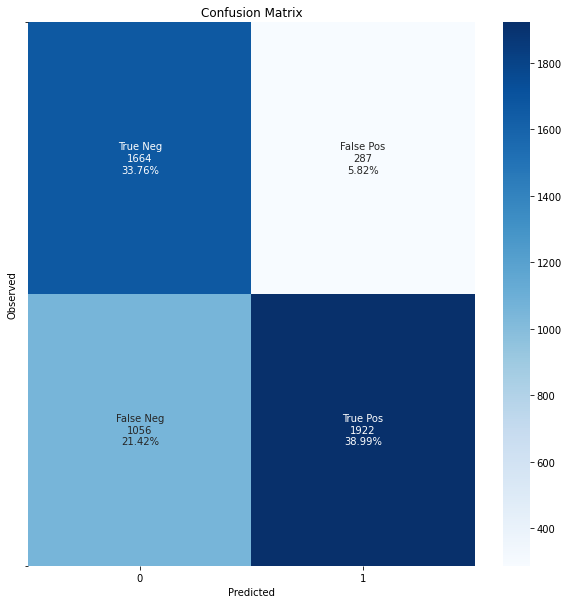

In [10]:
# Get probabilities and predictions for training data
ytrain_prob = logreg.predict_proba(scaled_X_train[f05])
ytrain_pred = logreg.predict(scaled_X_train[f05])

# Create confusion matrix for training data
cf_matrix = confusion_matrix(y_train, ytrain_pred)
print('Confusion Matrix:\n', cf_matrix)

# Visualize and label confusion matrix with values and percentages
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
pos, textvals = plt.yticks()
plt.yticks([0, 2], fontsize="10", va="center")
plt.title('Confusion Matrix')
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.show()

In [11]:
# Calculate accuracy on test set
ytest_prob = logreg.predict_proba(scaled_X_test[f05])
ytest_pred = logreg.predict(scaled_X_test[f05])
accuracy05 = logreg.score(scaled_X_test[f05], y_test)
print('Accuracy of classifier on test set: {:.5f}'.format(accuracy05))

# Print classification report
print('\nClassification report:\n', classification_report(y_test, ytest_pred))

Accuracy of classifier on test set: 0.72611

Classification report:
               precision    recall  f1-score   support

           0       0.61      0.84      0.71       961
           1       0.86      0.65      0.74      1467

    accuracy                           0.73      2428
   macro avg       0.74      0.74      0.72      2428
weighted avg       0.76      0.73      0.73      2428



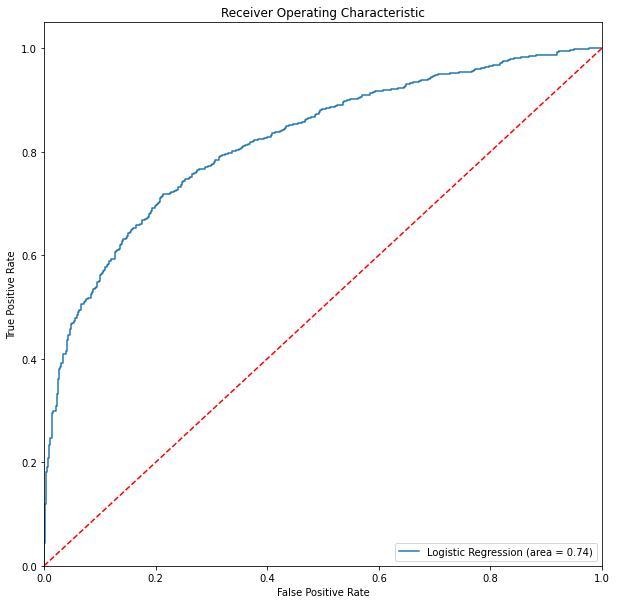

In [12]:
# Calculate ROC AUC score
logit_roc_auc = roc_auc_score(y_test, ytest_pred)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, ytest_prob[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()